<a href="https://colab.research.google.com/github/Joao-DLM/Projeto_NLP/blob/main/Analise_de_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **NLP - Analise de sentimentos**

Nós, humanos, aprendemos através da percepção. Todo nosso entendimento de mundo é baseado nos sentidos e explorados pela comunicação: falamos, lemos, escrevemos. Tecnicamente, tudo isso é quantitativo através dos dados não estruturados gerados.

NLP é uma parte da inteligência artificial que lida com o entendimento e processamento da linguagem humana. De uma maneira geral, é como se existisse uma nuvem de sintaxes e relações que nós fazemos. A NLP irá mesclar linguística, ciência da computação e IA, para basicamente representar através da vetorização dessas palavras tudo que pode ser interpretado e construído a partir disso.

### **Objetivo**

Esse notebook tem como objetivo treinar um modelo de analise de sentimentos com o Dataset: Brazilian E-Commerce Public Dataset by Olist (https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) Utilizando o Term Frequency-Inverse Document Frequency (Tf-idf), Bag of Words (BoW) e a biblioteca spacy.


Instalando as bibliotecas:

In [ ]:
# !pip install pandas seaborn

In [ ]:
# !pip install -U scikit-learn

Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
!pip install -U spacy==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.0 MB 4.2 MB/s 
     |████████████████████████████████| 10.1 MB 34.3 MB/s 
     |████████████████████████████████| 660 kB 68.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.1
    Uninstalling pydantic-1.9.1:
      Successfully uninstalled pydantic-1.9.1
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.1
    Uninstalling spacy-3.4.1:
      Successfully uninstalled spacy-3.4.1
ERROR: pip's dependency resolver does not currently take into account all t

In [3]:
import spacy
spacy.__version__

'3.2.0'

In [4]:
import spacy.cli
spacy.cli.download("pt_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [5]:
import pt_core_news_sm
spc_pt = pt_core_news_sm.load()

Limpando o dataset

In [6]:
# Lendo os dados
data = pd.read_csv('/content/olist_order_reviews_dataset.csv')
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [7]:
# Removendo colunas que não iremos usar para o modelo
data.drop(['order_id', 'review_creation_date', 'review_answer_timestamp'],
          1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   review_score            99224 non-null  int64 
 2   review_comment_title    11568 non-null  object
 3   review_comment_message  40977 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [9]:
# Checando se há dados duplicados
duplicados = round(sum(data.duplicated("review_id"))/len(data)*100, 2)
print(f"Reviews com id duplicado: {duplicados}%.")

Reviews com id duplicado: 0.82%.


In [10]:
data[data.duplicated("review_id", keep =  False)].sort_values(by = "review_id")

,review_id,review_score,review_comment_title,review_comment_message
46678,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
29841,00130cbe1f9d422698c812ed8ded1919,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
90677,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
63193,0115633a9c298b6a98bcbe4eee75345f,5,NaN,NaN
92876,0174caf0ee5964646040cd94e15ac95e,1,NaN,Produto entregue dentro de embalagem do fornec...
...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
82521,ff2fc9e68f8aabfbe18d710b83aabd30,2,NaN,NaN
73951,ffb8cff872a625632ac983eb1f88843c,3,NaN,NaN


In [11]:
# remove os duplicados
data.drop_duplicates("review_id", inplace = True)

In [12]:
# para nao ter problemas com nulos na concatenacao
data.fillna('', inplace = True)

In [13]:
# concatenando as duas colunas
data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message']

In [14]:
# removendo entradas sem texto
data = data[data['review'] != ' ']

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42389 entries, 3 to 99223
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [16]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."


Notas das avaliações (Review scores)

In [17]:
data['review_score'].value_counts()


5    21672
1     8723
4     6241
3     3615
2     2138
Name: review_score, dtype: int64

Há 5 valores de score diferentes (indo de 1 - pior até 5 - melhor), porém, para facilitar nossa tarefa, vamos classificar as reviews apenas como positiva ou negativa. Se o score for menor ou igual a 3, consideraremos negativa (0) e caso contrário, positiva (1).



In [18]:
labels = []

for score in data['review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

data['label'] = labels

In [19]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


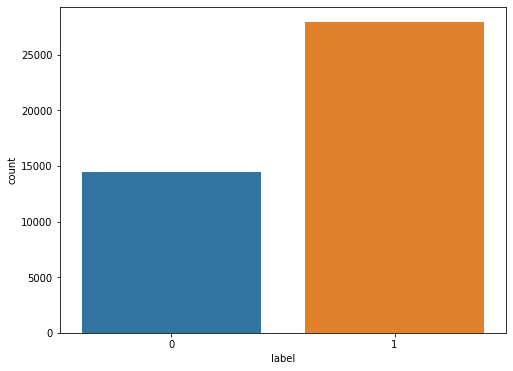

In [20]:
# Analisando graficamente a variável label:
plt.figure(figsize=(8,6))
sns.countplot(data['label'])
plt.show()

Há bem mais reviews positivas do que negativas.



**Pré-processamento do texto**

In [21]:
# Baixando as StopWords:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
# Selecionando as StopWords, em portugues:
stopwords_pt = stopwords.words("portuguese")

In [23]:
stopwords_pt

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [24]:
# Removendo palavras 'nao' e 'nem' das stopwords, pois podem ser importantes na analise de sentimentos
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [25]:
def limpa_texto(texto):
  '''(str) -> str
  Essa funcao recebe uma string, deixa tudo em minusculo, filtra apenas letras,
  retira stopwords, lemmatiza e retorna a string resultante.
  '''
  texto = texto.lower()

  texto = re.sub(r"[\W\d_]+", " ", texto)

  texto = [pal for pal in texto.split() if pal not in stopwords_pt]

  spc_texto = spc_pt(" ".join(texto))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]
  
  return " ".join(tokens)

In [26]:
# Aplicando a função
data['review'] = data['review'].apply(limpa_texto)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42389 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   review_score            42389 non-null  int64 
 2   review_comment_title    42389 non-null  object
 3   review_comment_message  42389 non-null  object
 4   review                  42389 non-null  object
 5   label                   42389 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [28]:
data.head()

,review_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,receber bem antar prazo estipular,1
4,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,parabém loja lannister adorar comprar internet...,1
9,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendar aparelhar eficiente site marcar apa...,1
12,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travar valor ta bom,1
15,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendar vendedor confiável produto ok...,1


In [29]:
data[data['review'] == '']

,review_id,review_score,review_comment_title,review_comment_message,review,label
297,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
463,3140a4eb146655fe104d54d385f9e9a0,5,,10,,1
583,3814f35a6ebd64d27e2130f30ec05255,4,5,,,1
598,057c9a1e8e767d8bf6fa59ac43a82435,4,4,,,1
939,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
...,...,...,...,...,...,...
94778,014f70270fa59804f14eb3df2ca690d2,5,,........................,,1
96770,47850e2adbd18f61f2af4af9b7656198,5,,👍🏻👌🏻👏🏻,,1
97441,e47fd0401fce7a7b6283da2a5a8ba563,5,10,,,1
98032,f004d8b3a2ff22e3c030285842cf629a,5,*****,,,1


In [30]:
#Removendo Review que contem apenas numeros ou simbolos
data = data[data['review'] != '']

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42129 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42129 non-null  object
 1   review_score            42129 non-null  int64 
 2   review_comment_title    42129 non-null  object
 3   review_comment_message  42129 non-null  object
 4   review                  42129 non-null  object
 5   label                   42129 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [32]:
# rode essa celula se quiser salvar o dataset pre-processado
data.to_csv('olist_preprocessado.csv', index= False, columns= ['review_id', 'review', 'label'])

Feature extraction

Bag of Words (BoW)

In [33]:
# Instanciando o CountVectorizer, binary=True faz a codificacao binaria
vectorizer = CountVectorizer(binary=True, max_features=5000)

texto = data['review']

# Vetorizando o texto
X_bow = vectorizer.fit_transform(texto)

In [34]:
X_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
print(X_bow.shape, type(X_bow))

(42129, 5000) <class 'scipy.sparse.csr.csr_matrix'>


TF-IDF

In [36]:
# Instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

# Vetorizando o texto
X_tfidf = tfidf_vect.fit_transform(texto)

In [37]:
print(X_tfidf)

  (0, 1829)	0.6930177056918921
  (0, 3652)	0.3048175571469909
  (0, 265)	0.35176399570299943
  (0, 566)	0.42742269783440073
  (0, 3964)	0.34696490478938935
  (1, 3847)	0.47804524004616217
  (1, 2002)	0.3029462021004615
  (1, 4578)	0.21243382086082635
  (1, 3820)	0.32293166978730814
  (1, 4285)	0.33158891013788655
  (1, 2487)	0.31321616645316197
  (1, 990)	0.12920572662182003
  (1, 85)	0.2155938698061523
  (1, 2595)	0.20599253812401627
  (1, 2698)	0.16861743952728736
  (1, 3318)	0.4338066160001956
  (2, 4818)	0.1833136645257773
  (2, 1145)	0.1654585680167312
  (2, 437)	0.2969417721496006
  (2, 3091)	0.2371287589370796
  (2, 3277)	0.14639091430985893
  (2, 855)	0.09475534658300816
  (2, 2375)	0.2943480316016456
  (2, 2799)	0.4016517582028187
  (2, 4363)	0.14923404626139672
  :	:
  (42126, 829)	0.22615463521242182
  (42126, 3550)	0.16790018263406714
  (42126, 2757)	0.21990995669187538
  (42126, 132)	0.16342085336143933
  (42126, 2022)	0.15771659896794255
  (42126, 1708)	0.3396051196232502

### **Modelo de NLP**

Primeiro, é preciso dividir os dados em base de treino (70%) e teste (30%).

In [38]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, data['label'],
                                                        test_size=0.3, random_state = 10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, data['label'],
                                                        test_size=0.3, random_state = 10)

Importando as métricas que serão usadas para avaliação de cada modelo:

In [39]:
def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
  principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

## **Regressão Logística**

Texto vetorizado com Bag of Words

In [40]:
# Instanciando a reg. logistica
reglog = LogisticRegression()
# Aplicando o modelo
reglog.fit(X1_train, y1_train)
# Predicao
y1_reglog_pred = reglog.predict(X1_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Acurácia:  0.8942954347654086

AUROC: 0.8781185885176626

F1-Score: 0.8937488373711415

Matriz de confusão:


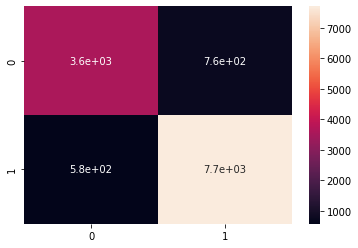

In [41]:
# Analisando as metricas
mostra_metricas(y1_test, y1_reglog_pred)

Texto vetorizado com tf-idf

In [42]:
# Instanciando a reg. logistica
reglog2 = LogisticRegression()
# Aplicando o modelo
reglog2.fit(X2_train, y2_train)
# Predicao
y2_reglog_pred = reglog2.predict(X2_test)

Acurácia:  0.8968272806392911

AUROC: 0.8847276824504497

F1-Score: 0.8967136655751446

Matriz de confusão:


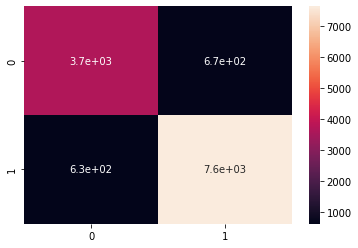

In [43]:
# Analisando as metricas
mostra_metricas(y2_test, y2_reglog_pred)

### **Naive Bayes Multinomial**

Utilizando o algoritmo Naive Bayes Multinomial para avaliar nosso modelo

BoW

Acurácia:  0.8889943824669673

AUROC: 0.8805456022687083

F1-Score: 0.8893572599641077

Matriz de confusão:


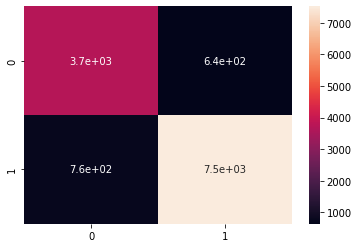

In [44]:
nb1 = MultinomialNB()

nb1.fit(X1_train.toarray(), y1_train)

y1_gnb_pred = nb1.predict(X1_test.toarray())

mostra_metricas(y1_test, y1_gnb_pred)


TF-IDF

Acurácia:  0.8890735026505262

AUROC: 0.8785936932671194

F1-Score: 0.8892220012513943

Matriz de confusão:


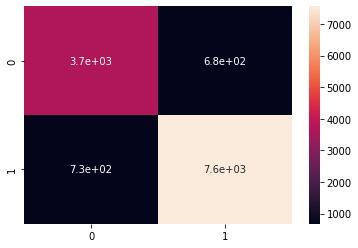

In [45]:
nb2 = MultinomialNB()

nb2.fit(X2_train.toarray(), y2_train)

y2_gnb_pred = nb2.predict(X2_test.toarray())

mostra_metricas(y2_test, y2_gnb_pred)

### **Random Forest**

Utilizando o algoritmo random forest para avaliar nosso modelo



BoW

Acurácia:  0.8928712714613498

AUROC: 0.88339505298011

F1-Score: 0.8930763748949558

Matriz de confusão:


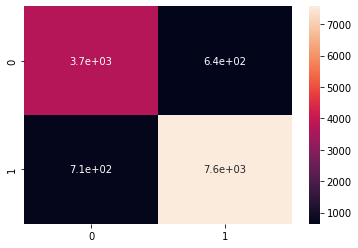

In [46]:
rf1 = RandomForestClassifier()

rf1.fit(X1_train, y1_train)

y1_dt_pred = rf1.predict(X1_test)

mostra_metricas(y1_test, y1_dt_pred)

TF-IDF

Acurácia:  0.8923965503599969

AUROC: 0.8836854532758145

F1-Score: 0.8926856692617069

Matriz de confusão:


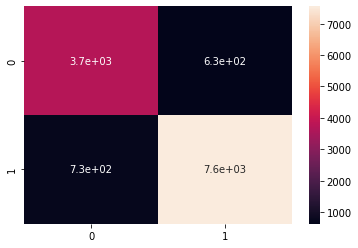

In [47]:
rf2 = RandomForestClassifier()

rf2.fit(X2_train, y2_train)

y2_dt_pred = rf2.predict(X2_test)

mostra_metricas(y2_test, y2_dt_pred)

### **Resultados**

através dos testes foi possivel identificar que o melhor modelo foi a regressão logística (com TF-IDF), com acurácia e F1 de 90% e AUROC de 89% (arredondando). Vamos testá-lo com um novo texto:

In [48]:
def nova_predicao(texto):
  '''Funcao que recebe uma string e printa a pedicao feita
  pelo modelo reglog2.'''
  texto_vetorizado = tfidf_vect.transform([texto])
  pred = reglog2.predict(texto_vetorizado)

  if pred == 0:
    print("Review negativa.")
  else:
    print("Review positiva.")

In [49]:
nova_predicao("Produto incrivel")

Review positiva.


In [50]:
nova_predicao("Demorou muito para entregar não gostei")

Review negativa.


In [51]:
nova_predicao("Produto de boa qualidade")

Review positiva.


In [52]:
nova_predicao("Nossa que produto ruim")

Review negativa.


### **Conclusão**

Com isso podemos dizer que o modelo apesar de simples teve uma boa performace e a diferença entre usar Bag of Words ou TF-IDF foi bem pequena. Os modelos apresentaram melhores métricas com TF-IDF exeto no caso do Naive Bayes.